# U.S. mail voting statistics

#### Source: U.S. Election Assistance Commission [survey](https://www.eac.gov/research-and-data/datasets-codebooks-and-surveys)

In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = 50
pd.options.display.max_rows = 34000
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.1f}'.format

### Read data from the 2018 general election

In [2]:
src = pd.read_csv('input/EAVS_2018_for_Public_Release_Updates3.csv', low_memory=False, na_values=['(NA)']).fillna(0)

### Reduce the number of columns to those we're interested in, and give them useful names

In [3]:
mail_ballots = src[[ 'FIPSCode', 'Jurisdiction_Name', 'State_Abbr', 'A1b', 'C1a', 'C1b', 'C3a', 'C4e', 'C4a', 'D1a']].fillna('')

In [4]:
mail_ballots = mail_ballots.rename(columns={ 'FIPSCode':'fips', 'State_Abbr':'state', \
                                            'Jurisdiction_Name':'place','A1b':'active_voters', 'C1a':'mail_ballots_sent', \
                             'C1b':'mail_ballots_returned', 'C3a':'mail_ballots_counted', 'C4a':'mail_ballots_rejected', \
                             'D1a': 'total_votes_cast', 'C4e':'non_match_sig'  })

### Clean up numeric columns that contain strings for missing data

In [5]:
strings = ['Data not available', 'Does not apply']
columns = ['active_voters', 'mail_ballots_sent', 'mail_ballots_returned',\
           'mail_ballots_counted', 'mail_ballots_rejected', 'total_votes_cast', 'non_match_sig']

In [6]:
mail_ballots[columns] = mail_ballots[columns].apply(pd.to_numeric, errors='coerce', axis=1)

In [7]:
mail_ballots['fips'] = mail_ballots['fips'].astype(str).str.replace('00000','').str.zfill(5)

### Isolate swing states

In [8]:
# Those in the middle of the snake: https://projects.fivethirtyeight.com/2020-election-forecast/
swing = ['MI','OH','PA','NC','WI','AZ','FL','NV', 'MN']

In [9]:
mail_ballots['mail_ballots_rejected'] = mail_ballots['mail_ballots_rejected'].replace(-88, 0)
mail_ballots['non_match_sig'] = mail_ballots['non_match_sig'].replace(-88, 0)

---

### National totals

#### Total mail ballots rejected

In [10]:
mail_ballots['mail_ballots_rejected'].sum()

430196.0

In [11]:
mail_ballots['non_match_sig'].sum()

63569.0

#### % of mail ballots rejected

In [12]:
(((mail_ballots['mail_ballots_rejected'].sum() / mail_ballots['mail_ballots_returned'].sum())*100)).round(2)

1.42

#### % of those rejected because of non-matching signature

In [13]:
(((mail_ballots['non_match_sig'].sum() / mail_ballots['mail_ballots_rejected'].sum())*100)).round(2)

14.78

#### % of all votes cast that were mail ballots

In [14]:
(((mail_ballots['mail_ballots_counted'].sum() / mail_ballots['total_votes_cast'].sum())*100)).round(2)

23.64

---

### Aggregate by state

In [15]:
states = mail_ballots.groupby(['state']).agg('sum').reset_index()

### Calculate our rates for states

In [16]:
states['mail_rejected_rate'] = ((states['mail_ballots_rejected'] / states['mail_ballots_returned'])*100)

In [17]:
states['mail_pct_all_votes'] = ((states['mail_ballots_counted'] / states['total_votes_cast'])*100)

### Signature mismatch as a reason for the rejection

In [18]:
states['mail_rejected_sig_pct'] = ((states['non_match_sig'] / states['mail_ballots_rejected'])*100)

In [19]:
states['mail_rejected_sig_pct_all'] = ((states['non_match_sig'] / states['mail_ballots_returned'])*100)

In [20]:
states.head()

,state,active_voters,mail_ballots_sent,mail_ballots_returned,mail_ballots_counted,non_match_sig,mail_ballots_rejected,total_votes_cast,mail_rejected_rate,mail_pct_all_votes,mail_rejected_sig_pct,mail_rejected_sig_pct_all
0,AK,"571,851.0","29,257.0","24,425.0","23,667.0",0.0,758.0,"285,009.0",3.1,8.3,0.0,0.0
1,AL,"3,164,301.0","63,291.0","57,832.0","54,833.0",0.0,"1,368.0","1,726,638.0",2.4,3.2,0.0,0.0
2,AR,"1,456,887.0","17,120.0","15,208.0","11,611.0",21.0,"1,150.0","814,887.0",7.6,1.4,1.8,0.1
3,AS,"8,462.0",51.0,36.0,0.0,0.0,0.0,"8,462.0",0.0,0.0,nan,0.0
4,AZ,"3,715,624.0","2,672,384.0","1,899,240.0","1,874,489.0","1,516.0","8,567.0","2,409,906.0",0.5,77.8,17.7,0.1


### Merge AP states

In [21]:
ap = pd.read_csv('input/ap_states.csv')

In [22]:
ap.head()

,name,usps,ap
0,Alabama,AL,Ala.
1,Alaska,AK,Alaska
2,Arizona,AZ,Ariz.
3,Arkansas,AR,Ark.
4,California,CA,Calif.


In [23]:
states_ap = pd.merge(ap, states, left_on='usps', right_on='state')

In [24]:
states_ap = states_ap.drop(['usps'], axis=1)

In [25]:
states_ap[['state', 'ap', 'name', 'mail_ballots_returned', 'mail_ballots_counted', 'mail_ballots_rejected', \
        'mail_rejected_sig_pct', 'mail_rejected_sig_pct_all']]\
.sort_values('mail_rejected_sig_pct', ascending=False).to_csv('output/mail_rejected_sig_pct.csv', index=False)

In [26]:
states_ap[['state', 'ap', 'name', 'mail_ballots_returned', 'mail_ballots_counted', 'mail_ballots_rejected', \
        'mail_rejected_sig_pct', 'mail_rejected_sig_pct_all']]\
.sort_values('mail_rejected_sig_pct', ascending=False).head(60)

,state,ap,name,mail_ballots_returned,mail_ballots_counted,mail_ballots_rejected,mail_rejected_sig_pct,mail_rejected_sig_pct_all
5,CO,Colo.,Colorado,"2,449,409.0","2,430,239.0","19,170.0",68.0,0.5
34,ND,N.D.,North Dakota,"96,125.0","95,562.0",554.0,60.3,0.3
47,WA,Wash.,Washington,"3,112,157.0","3,064,219.0","32,327.0",53.3,0.6
39,RI,R.I.,Rhode Island,"27,193.0","26,418.0",775.0,43.1,1.2
44,UT,Utah,Utah,"973,915.0","965,147.0","8,768.0",36.7,0.3
37,OR,Ore.,Oregon,"1,907,342.0","7,043.0",176.0,35.2,0.0
11,HI,Hawaii,Hawaii,"224,404.0","195,149.0","1,638.0",35.2,0.3
26,MT,Mont.,Montana,"367,561.0","366,188.0","1,373.0",28.4,0.1
43,TX,Texas,Texas,"533,566.0","527,787.0","9,377.0",20.0,0.4
2,AZ,Ariz.,Arizona,"1,899,240.0","1,874,489.0","8,567.0",17.7,0.1


### States with highest mail ballot rejection rates?

In [27]:
states_ap.sort_values('mail_rejected_rate', ascending=False).head(10)

,name,ap,state,active_voters,mail_ballots_sent,mail_ballots_returned,mail_ballots_counted,non_match_sig,mail_ballots_rejected,total_votes_cast,mail_rejected_rate,mail_pct_all_votes,mail_rejected_sig_pct,mail_rejected_sig_pct_all
32,New York,N.Y.,NY,"11,676,266.0","341,270.0","249,002.0","226,151.0",175.0,"34,095.0","6,230,976.0",13.7,3.6,0.5,0.1
3,Arkansas,Ark.,AR,"1,456,887.0","17,120.0","15,208.0","11,611.0",21.0,"1,150.0","814,887.0",7.6,1.4,1.8,0.1
17,Kentucky,Ky.,KY,"3,402,905.0","29,244.0","25,837.0","23,971.0",46.0,"1,756.0","1,617,840.0",6.8,1.5,2.6,0.2
33,North Carolina,N.C.,NC,"5,898,244.0","126,142.0","95,546.0","89,711.0",33.0,"5,835.0","3,754,895.0",6.1,2.4,0.6,0.0
18,Louisiana,La.,LA,"2,856,722.0","65,442.0","43,959.0","41,363.0",17.0,"2,596.0","1,519,552.0",5.9,2.7,0.7,0.0
21,Massachusetts,Mass.,MA,"3,947,897.0","105,454.0","89,437.0","84,280.0",0.0,"5,157.0","2,752,665.0",5.8,3.1,0.0,0.0
7,Delaware,Del.,DE,"672,632.0","17,392.0","14,142.0","13,436.0",0.0,706.0,"366,550.0",5.0,3.7,0.0,0.0
36,Oklahoma,Okla.,OK,"1,857,700.0","94,598.0","69,771.0","66,160.0",0.0,"3,136.0","1,190,767.0",4.5,5.6,0.0,0.0
38,Pennsylvania,Pa.,PA,"7,738,989.0","216,575.0","195,953.0","186,664.0",0.0,"8,714.0","5,058,288.0",4.4,3.7,0.0,0.0
8,District of Columbia,D.C.,DC,"511,633.0","12,400.0","9,351.0","9,019.0",44.0,332.0,"231,700.0",3.6,3.9,13.3,0.5


### States with highest vote by mail rates?

In [28]:
states_ap.sort_values('mail_rejected_rate', ascending=False).to_csv('output/states_mail_rejected_rate.csv', index=False)

### Calculate our rates for counties

In [29]:
mail_ballots['mail_ballots_rejected'] = mail_ballots['mail_ballots_rejected'].replace(-88, 0)

In [30]:
mail_ballots['mail_rejected_rate'] = ((mail_ballots['mail_ballots_rejected'] / mail_ballots['mail_ballots_returned'])*100)

In [31]:
mail_ballots['mail_rejected_sig_pct_all'] = ((mail_ballots['non_match_sig'] / mail_ballots['mail_ballots_returned'])*100)

In [32]:
mail_ballots['mail_rejected_sig_pct'] = ((mail_ballots['non_match_sig'] / mail_ballots['mail_ballots_rejected'])*100)

In [33]:
mail_ballots['mail_pct_all_votes'] = ((mail_ballots['mail_ballots_counted'] / mail_ballots['total_votes_cast'])*100)

### Populous places in 'swing' states with the highest rates?

In [34]:
mail_ballots[(mail_ballots['state'].isin(swing)) &\
            (mail_ballots['active_voters'] > 500000)].sort_values('mail_rejected_rate', ascending=False).head(5)

,fips,place,state,active_voters,mail_ballots_sent,mail_ballots_returned,mail_ballots_counted,non_match_sig,mail_ballots_rejected,total_votes_cast,mail_rejected_rate,mail_rejected_sig_pct_all,mail_rejected_sig_pct,mail_pct_all_votes
3562,42091,MONTGOMERY COUNTY,PA,"523,501.0","19,598.0","17,235.0","15,771.0",nan,"1,382.0","384,750.0",8.0,nan,nan,4.1
3254,37183,WAKE COUNTY,NC,"645,373.0","21,094.0","15,889.0","15,182.0",0.0,707.0,"439,278.0",4.4,0.0,0.0,3.5
3567,42101,PHILADELPHIA COUNTY,PA,"937,687.0","12,841.0","10,045.0","9,617.0",nan,428.0,"564,549.0",4.3,nan,nan,1.7
3222,37119,MECKLENBURG COUNTY,NC,"628,180.0","16,050.0","12,875.0","12,343.0",0.0,532.0,"378,267.0",4.1,0.0,0.0,3.3
2711,32003,CLARK COUNTY,NV,"1,096,900.0","61,154.0","48,665.0","47,365.0",60.0,"1,300.0","655,497.0",2.7,0.1,4.6,7.2


In [35]:
mail_ballots[(mail_ballots['active_voters'] > 500000) & (mail_ballots['mail_ballots_rejected'] > 100)]\
    [['place', 'state', 'mail_ballots_returned', 'mail_ballots_rejected', 'non_match_sig','mail_rejected_sig_pct', 'mail_rejected_sig_pct_all']]\
    .sort_values('mail_rejected_sig_pct', ascending=False).head(20)

,place,state,mail_ballots_returned,mail_ballots_rejected,non_match_sig,mail_rejected_sig_pct,mail_rejected_sig_pct_all
4509,KING COUNTY,WA,"962,594.0","12,209.0","7,457.0",61.1,0.8
194,SAN BERNARDINO COUNTY,CA,"334,180.0","5,029.0","3,028.0",60.2,0.9
3886,DALLAS COUNTY,TX,"41,681.0",294.0,157.0,53.4,0.4
4101,SALT LAKE COUNTY,UT,"375,026.0","2,582.0","1,244.0",48.2,0.3
4049,TARRANT COUNTY,TX,"35,815.0",342.0,152.0,44.4,0.4
165,CONTRA COSTA COUNTY,CA,"290,510.0","1,749.0",768.0,43.9,0.3
192,SACRAMENTO COUNTY,CA,"477,153.0","3,837.0","1,605.0",41.8,0.3
79,PIMA COUNTY,AZ,"304,048.0","1,278.0",488.0,38.2,0.2
195,SAN DIEGO COUNTY,CA,"803,546.0","3,687.0","1,310.0",35.5,0.2
503,PALM BEACH COUNTY,FL,"157,177.0","2,226.0",785.0,35.3,0.5


### Just counties with more than 50,000 voters

In [36]:
mail_ballots_large = mail_ballots[mail_ballots['active_voters'] > 50000]

### Isolate just California 

In [37]:
mail_ballots_ca = mail_ballots[mail_ballots['state'] == 'CA']

### What's up in Los Angeles County? 

In [38]:
mail_ballots[(mail_ballots['state'] == 'CA') &\
(mail_ballots['place'] == 'LOS ANGELES COUNTY')].iloc[0]

fips                                      06037
place                        LOS ANGELES COUNTY
state                                        CA
active_voters                       5,280,658.0
mail_ballots_sent                   2,723,457.0
mail_ballots_returned               1,346,022.0
mail_ballots_counted                1,330,611.0
non_match_sig                               0.0
mail_ballots_rejected                  15,412.0
total_votes_cast                    3,023,417.0
mail_rejected_rate                          1.1
mail_rejected_sig_pct_all                   0.0
mail_rejected_sig_pct                       0.0
mail_pct_all_votes                         44.0
Name: 177, dtype: object

### Which California counties have the highest rejection rates?

In [39]:
mail_ballots_ca.sort_values('mail_rejected_rate', ascending=False).head(10)

,fips,place,state,active_voters,mail_ballots_sent,mail_ballots_returned,mail_ballots_counted,non_match_sig,mail_ballots_rejected,total_votes_cast,mail_rejected_rate,mail_rejected_sig_pct_all,mail_rejected_sig_pct,mail_pct_all_votes
169,06021,GLENN COUNTY,CA,"12,816.0","19,517.0","7,578.0","6,838.0",50.0,"1,181.0","8,441.0",15.6,0.7,4.2,81.0
176,06035,LASSEN COUNTY,CA,"14,332.0","11,972.0","8,065.0","7,082.0",3.0,983.0,"9,154.0",12.2,0.0,0.3,77.4
182,06047,MERCED COUNTY,CA,"97,584.0","73,874.0","43,601.0","40,108.0",658.0,"3,493.0","57,491.0",8.0,1.5,18.8,69.8
173,06029,KERN COUNTY,CA,"375,759.0","252,121.0","136,408.0","134,054.0","1,214.0","10,471.0","205,816.0",7.7,0.9,11.6,65.1
183,06049,MODOC COUNTY,CA,"5,118.0","3,869.0","2,833.0","2,623.0",6.0,210.0,"3,497.0",7.4,0.2,2.9,75.0
174,06031,KINGS COUNTY,CA,"52,631.0","43,039.0","25,188.0","23,375.0",112.0,"1,813.0","30,606.0",7.2,0.4,6.2,76.4
216,06115,YUBA COUNTY,CA,"33,754.0","23,084.0","14,704.0","13,682.0",169.0,"1,022.0","19,643.0",7.0,1.1,16.5,69.7
212,06107,TULARE COUNTY,CA,"169,367.0","122,369.0","75,394.0","70,652.0",337.0,"4,742.0","101,066.0",6.3,0.4,7.1,69.9
168,06019,FRESNO COUNTY,CA,"456,891.0","289,112.0","163,391.0","161,151.0",370.0,"9,148.0","256,972.0",5.6,0.2,4.0,62.7
178,06039,MADERA COUNTY,CA,"57,418.0","58,537.0","36,457.0","34,489.0",255.0,"1,968.0","38,890.0",5.4,0.7,13.0,88.7


### Which large U.S. counties have the highest rejection rates?

In [40]:
mail_ballots_large.sort_values('mail_rejected_rate', ascending=False).head(10)

,fips,place,state,active_voters,mail_ballots_sent,mail_ballots_returned,mail_ballots_counted,non_match_sig,mail_ballots_rejected,total_votes_cast,mail_rejected_rate,mail_rejected_sig_pct_all,mail_rejected_sig_pct,mail_pct_all_votes
3124,36047,KINGS COUNTY,NY,"1,460,396.0","29,638.0","20,840.0","16,269.0",0.0,"7,498.0","645,096.0",36.0,0.0,0.0,2.5
3141,36081,QUEENS COUNTY,NY,"1,180,052.0","22,226.0","17,271.0","13,375.0",0.0,"6,212.0","504,309.0",36.0,0.0,0.0,2.7
3131,36061,NEW YORK COUNTY,NY,"1,016,771.0","33,498.0","25,950.0","21,885.0",0.0,"7,010.0","540,445.0",27.0,0.0,0.0,4.0
680,66000,GUAM,GU,"55,941.0",624.0,367.0,298.0,nan,69.0,"37,386.0",18.8,nan,nan,0.8
3136,36071,ORANGE COUNTY,NY,"220,262.0","8,370.0","6,370.0","5,702.0",18.0,"1,174.0","125,924.0",18.4,0.3,1.5,4.5
3236,37147,PITT COUNTY,NC,"101,939.0","1,168.0",857.0,702.0,1.0,155.0,"59,917.0",18.1,0.1,0.6,1.2
3160,36119,WESTCHESTER COUNTY,NY,"593,559.0","23,831.0","10,409.0","18,303.0",0.0,"1,736.0","339,931.0",16.7,0.0,0.0,5.4
3103,36005,BRONX COUNTY,NY,"721,734.0","10,145.0","7,303.0","6,526.0",0.0,"1,140.0","292,565.0",15.6,0.0,0.0,2.2
777,17093,KENDALL COUNTY,IL,"78,227.0","2,819.0","2,445.0","2,445.0",nan,367.0,"46,201.0",15.0,nan,nan,5.3
3191,37057,DAVIDSON COUNTY,NC,"91,376.0","2,022.0","1,641.0","1,406.0",2.0,235.0,"57,427.0",14.3,0.1,0.9,2.4


---

## Geography

### All U.S. counties

In [41]:
counties_geo = gpd.read_file('input/county_w_lakes_small.json')

### CA counties

In [42]:
counties_ca_geo = counties_geo[counties_geo['statefp']=='06']

<AxesSubplot:>

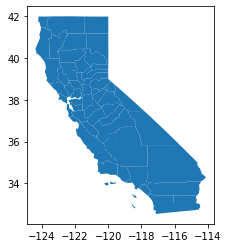

In [43]:
counties_ca_geo.plot()

### States

In [44]:
states_geo = gpd.read_file('input/states.json')

<AxesSubplot:>

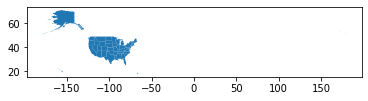

In [45]:
states_geo.plot()

### Townships

In [46]:
townships_geo = gpd.read_file('input/tl_2018_23_cousub/tl_2018_23_cousub.shp')

<AxesSubplot:>

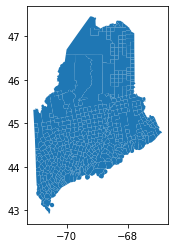

In [47]:
townships_geo.plot()

In [48]:
mail_ballots_geo_counties = counties_geo.merge(mail_ballots, left_on='geoid', right_on='fips')

In [49]:
mail_ballots_geo_ca_counties = counties_ca_geo.merge(mail_ballots_ca, left_on='geoid', right_on='fips')

In [50]:
mail_ballots_geo_states = states_geo.merge(states, left_on='STUSPS', right_on='state')

### Export geo files

In [51]:
mail_ballots_geo_counties.to_file('output/mail_ballots_geo_counties.geojson', driver='GeoJSON')

In [52]:
mail_ballots_geo_states.to_file('output/mail_ballots_geo_states.geojson', driver='GeoJSON')

In [53]:
mail_ballots_geo_ca_counties.to_file('output/mail_ballots_geo_ca_counties.geojson', driver='GeoJSON')

### Export text files

In [54]:
states.to_csv('output/states.csv', index=False)

In [55]:
mail_ballots_ca.to_csv('output/mail_ballots_ca.csv', index=False)